### Joslin

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [2]:
PATH = 'datasets/joslin/'

In [3]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [4]:
df = pd.read_csv(text_path)
df

,ID,EYE_DR,text,DR_2,DR_3,split
0,41346,0,An image from the right eye of a female patien...,0,0,train
1,86312,0,"An image from the right eye of a male patient,...",0,0,test
2,161175,0,An image from the right eye of a female patien...,0,0,train
3,185158,0,"An image from the right eye of a male patient,...",0,0,train
4,65272,0,"An image from the left eye of a male patient, ...",0,0,train
...,...,...,...,...,...,...
1788,92630,4,"An image from the right eye of a male patient,...",1,2,train
1789,176584,4,"An image from the right eye of a male patient,...",1,2,train
1790,125952,4,An image from the right eye of a female patien...,1,2,test
1791,179865,4,An image from the left eye of a female patient...,1,2,test


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'ID'
label_columns = 'DR_3'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

  0%|          | 0/1793 [00:00<?, ?it/s]

100%|██████████| 1793/1793 [00:01<00:00, 963.02it/s] 


0        datasets/joslin/images/41346.jpeg
1        datasets/joslin/images/86312.jpeg
2       datasets/joslin/images/161175.jpeg
3       datasets/joslin/images/185158.jpeg
4        datasets/joslin/images/65272.jpeg
                       ...                
1788     datasets/joslin/images/92630.jpeg
1789    datasets/joslin/images/176584.jpeg
1790    datasets/joslin/images/125952.jpeg
1791    datasets/joslin/images/179865.jpeg
1792     datasets/joslin/images/64435.jpeg
Name: ID, Length: 1793, dtype: object
(1793, 6)


100%|██████████| 1793/1793 [00:42<00:00, 42.43it/s]


(1793, 6)
Train Shape: (1434, 6)
Test Shape: (359, 6)
0       0
2       0
3       0
4       0
5       0
       ..
1785    2
1787    2
1788    2
1789    2
1792    2
Name: DR_3, Length: 1434, dtype: int64
1       0
13      0
20      0
21      0
34      0
       ..
1778    2
1781    2
1786    2
1790    2
1791    2
Name: DR_3, Length: 359, dtype: int64


In [6]:
df

,ID,EYE_DR,text,DR_2,DR_3,split
0,datasets/joslin/images/41346.jpeg,0,An image from the right eye of a female patien...,0,0,train
1,datasets/joslin/images/86312.jpeg,0,"An image from the right eye of a male patient,...",0,0,test
2,datasets/joslin/images/161175.jpeg,0,An image from the right eye of a female patien...,0,0,train
3,datasets/joslin/images/185158.jpeg,0,"An image from the right eye of a male patient,...",0,0,train
4,datasets/joslin/images/65272.jpeg,0,"An image from the left eye of a male patient, ...",0,0,train
...,...,...,...,...,...,...
1788,datasets/joslin/images/92630.jpeg,4,"An image from the right eye of a male patient,...",1,2,train
1789,datasets/joslin/images/176584.jpeg,4,"An image from the right eye of a male patient,...",1,2,train
1790,datasets/joslin/images/125952.jpeg,4,An image from the right eye of a female patien...,1,2,test
1791,datasets/joslin/images/179865.jpeg,4,An image from the left eye of a female patient...,1,2,test


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197379
Epoch 1/30 - Test Accuracy: 0.3398, macro-f1: 0.3238
Epoch 1/30 - Training Time: 175.73 seconds | Inference Time: 62.99 seconds
Epoch 2/30 - Test Accuracy: 0.4206, macro-f1: 0.3899
Epoch 2/30 - Training Time: 178.82 seconds | Inference Time: 62.94 seconds
Epoch 3/30 - Test Accuracy: 0.5097, macro-f1: 0.4275
Epoch 3/30 - Training Time: 177.04 seconds | Inference Time: 63.39 seconds
Epoch 4/30 - Test Accuracy: 0.3844, macro-f1: 0.3557
Epoch 4/30 - Training Time: 176.44 seconds | Inference Time: 62.08 seconds
Epoch 5/30 - Test Accuracy: 0.3287, macro-f1: 0.3268
Epoch 5/30 - Training Time: 174.70 seconds | Inference Time: 63.66 seconds
Epoch 6/30 - Test Accuracy: 0.4067, macro-f1: 0.3710
Epoch 6/30 - Training Time: 177.57 seconds | Inference Time: 63.68 seconds
Epoch 7/30 - Test Accuracy: 0.4708, macro-f1: 0.4252
Epoch 7/30 - Training Time: 178.18 seconds | Inference Time: 64.71 seconds
Epoch 8/30 - Test Accurac

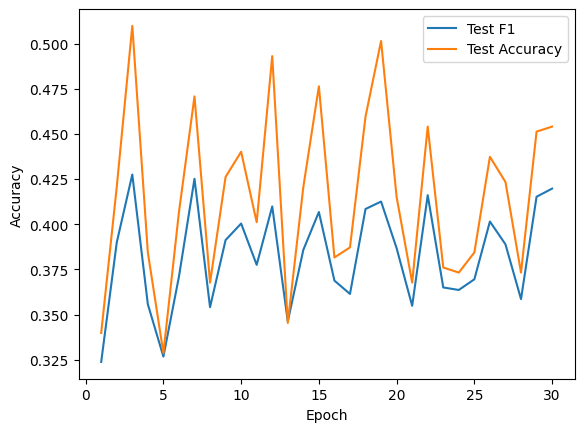

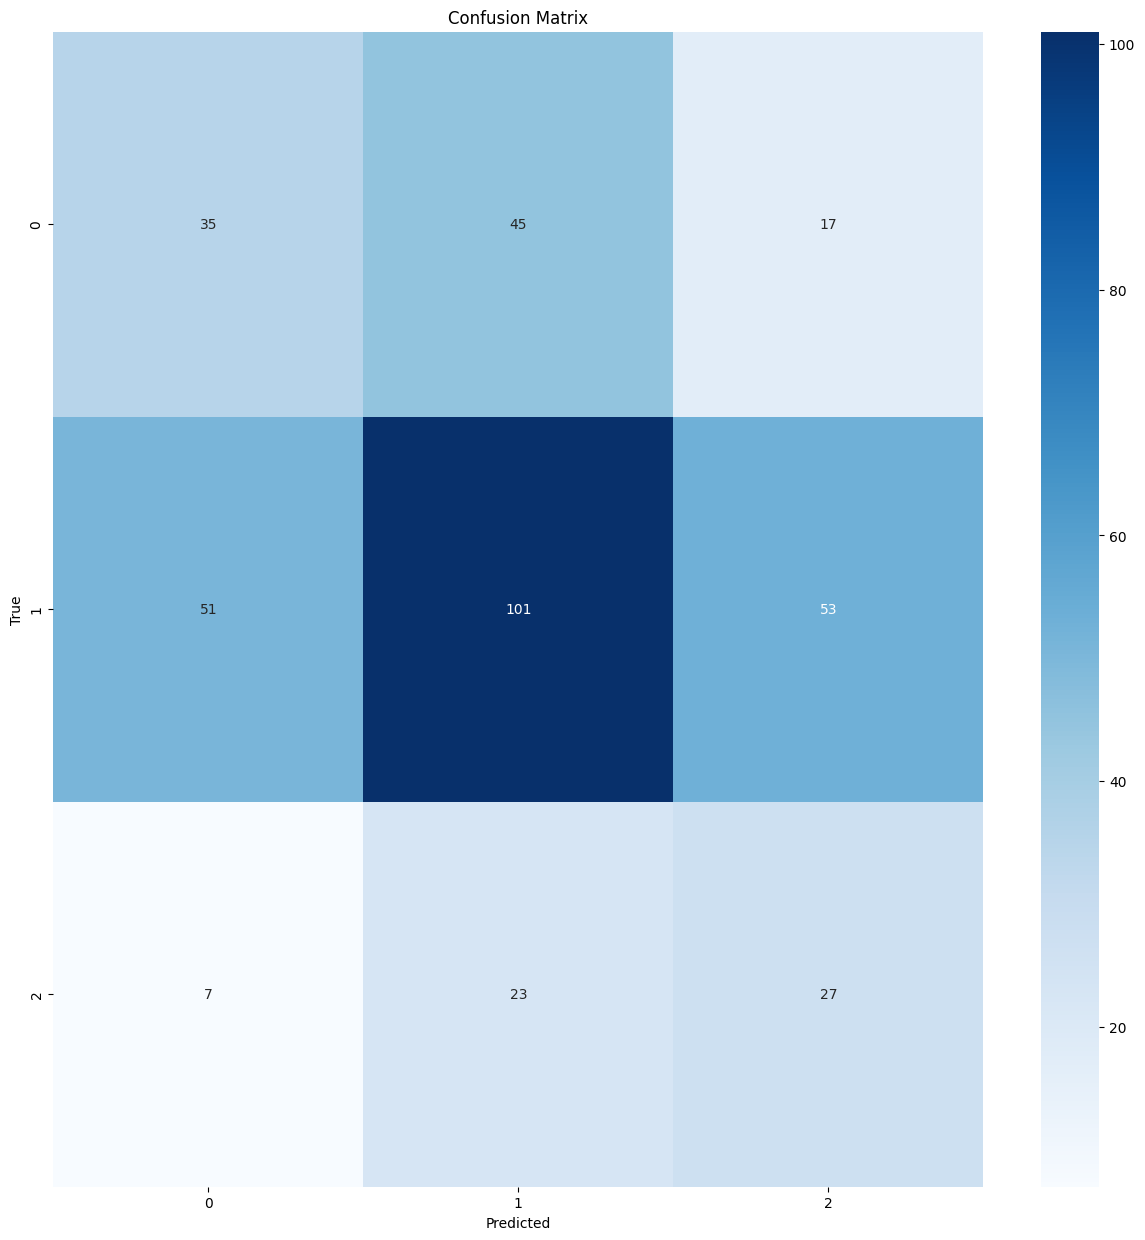

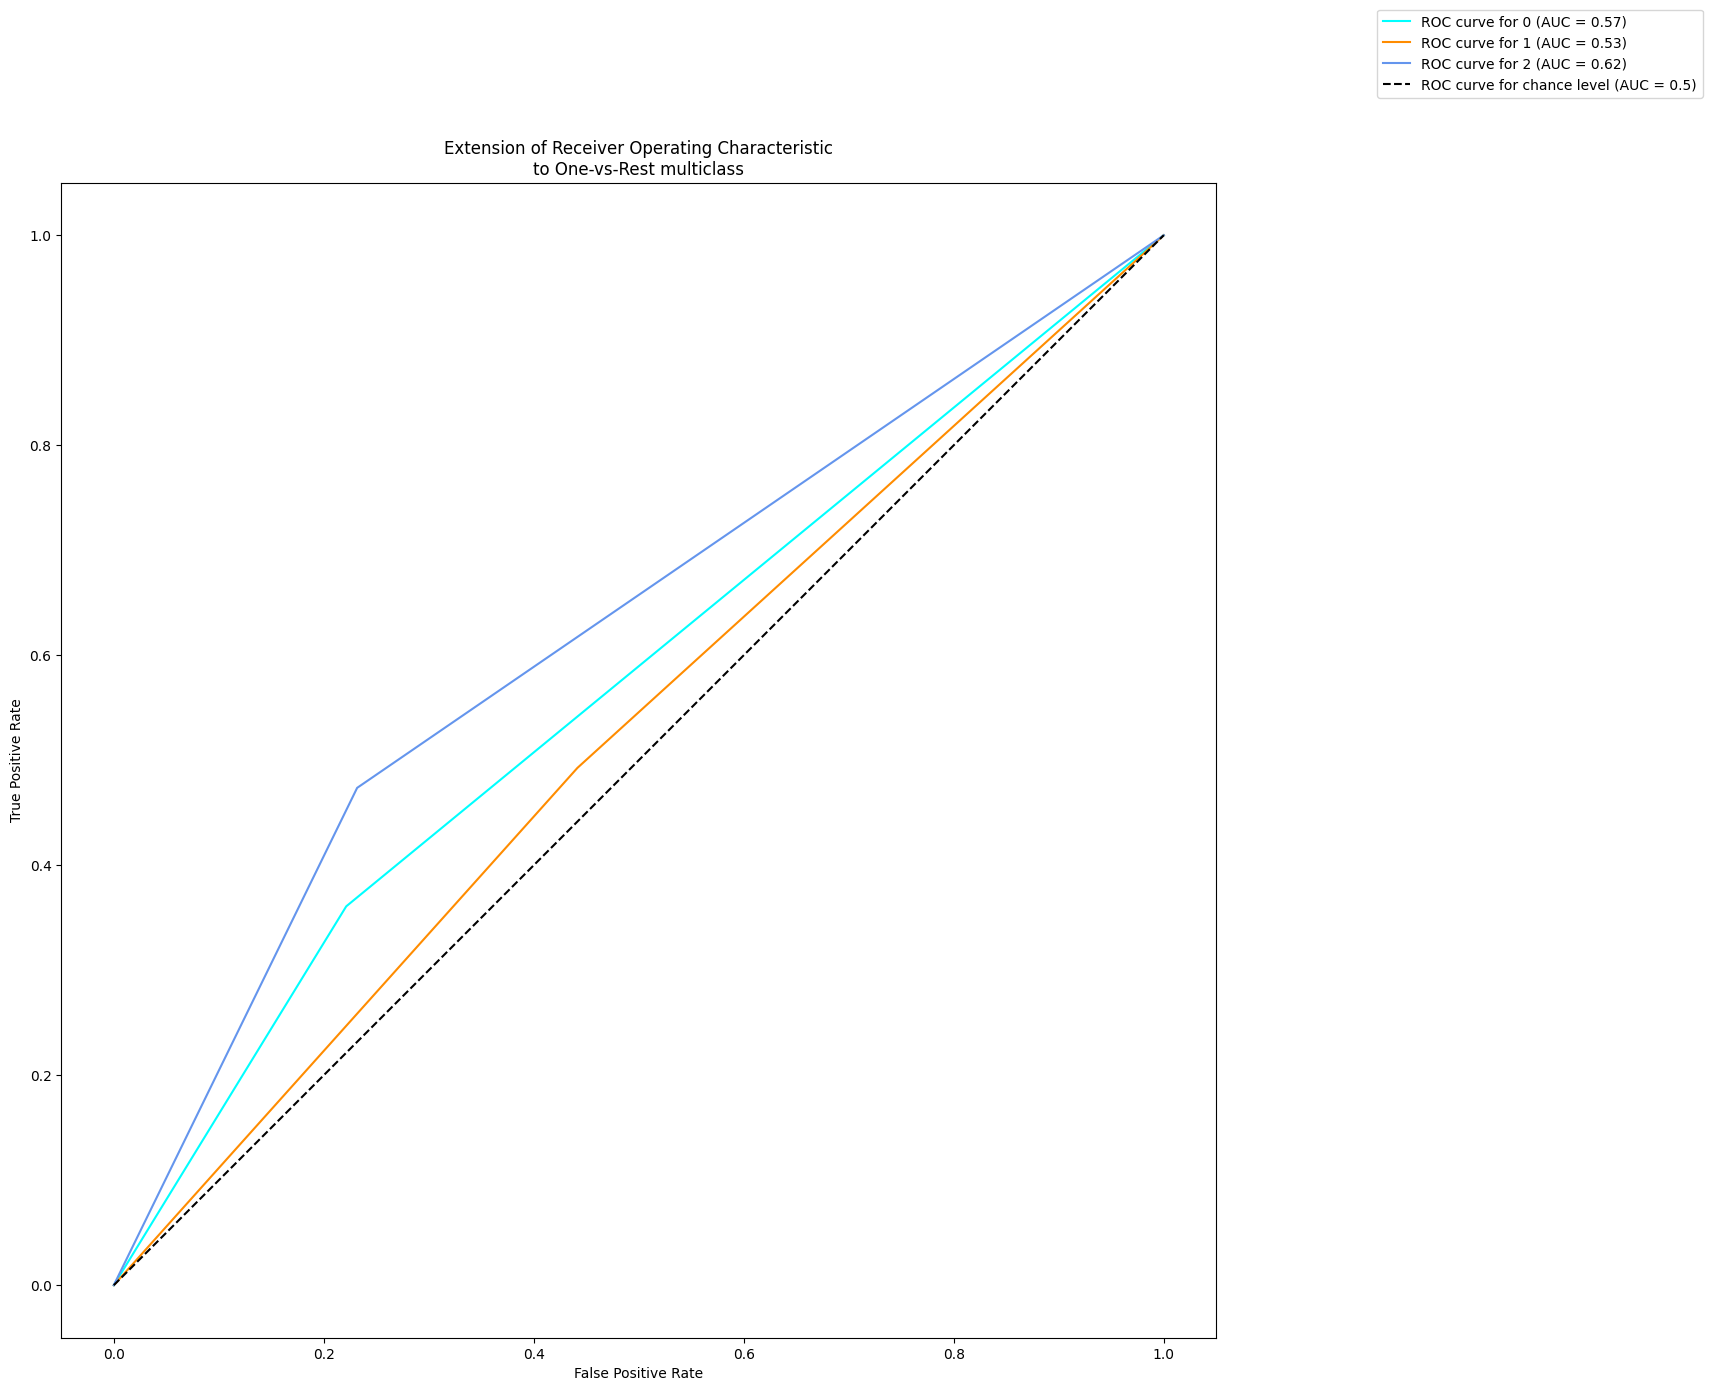

              precision    recall  f1-score   support

           0       0.38      0.36      0.37        97
           1       0.60      0.49      0.54       205
           2       0.28      0.47      0.35        57

    accuracy                           0.45       359
   macro avg       0.42      0.44      0.42       359
weighted avg       0.49      0.45      0.46       359



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 99075
Epoch 1/30 - Test Accuracy: 0.5376, macro-f1: 0.4297
Epoch 1/30 - Training Time: 297.76 seconds | Inference Time: 61.54 seconds
Epoch 2/30 - Test Accuracy: 0.4485, macro-f1: 0.3827
Epoch 2/30 - Training Time: 771.99 seconds | Inference Time: 360.22 seconds
Epoch 3/30 - Test Accuracy: 0.3677, macro-f1: 0.3400
Epoch 3/30 - Training Time: 471.02 seconds | Inference Time: 62.18 seconds
Epoch 4/30 - Test Accuracy: 0.4345, macro-f1: 0.4093
Epoch 4/30 - Training Time: 218.20 seconds | Inference Time: 61.06 seconds
Epoch 5/30 - Test Accuracy: 0.3565, macro-f1: 0.3462
Epoch 5/30 - Training Time: 475.29 seconds | Inference Time: 359.00 seconds
Epoch 6/30 - Test Accuracy: 0.3510, macro-f1: 0.3336
Epoch 6/30 - Training Time: 470.53 seconds | Inference Time: 61.26 seconds
Epoch 7/30 - Test Accuracy: 0.3482, macro-f1: 0.3284
Epoch 7/30 - Training Time: 545.01 seconds | Inference Time: 967.08 seconds
Epoch 8/30 - Test Accura

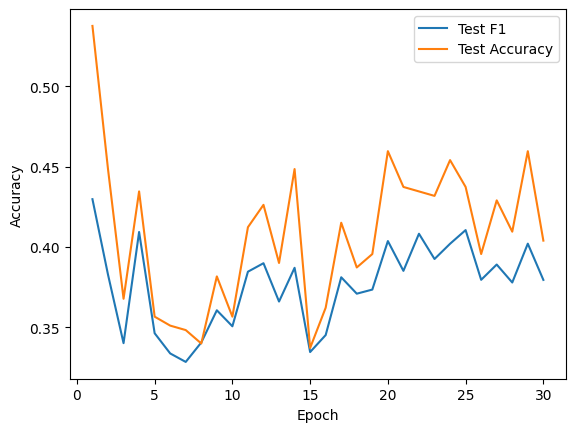

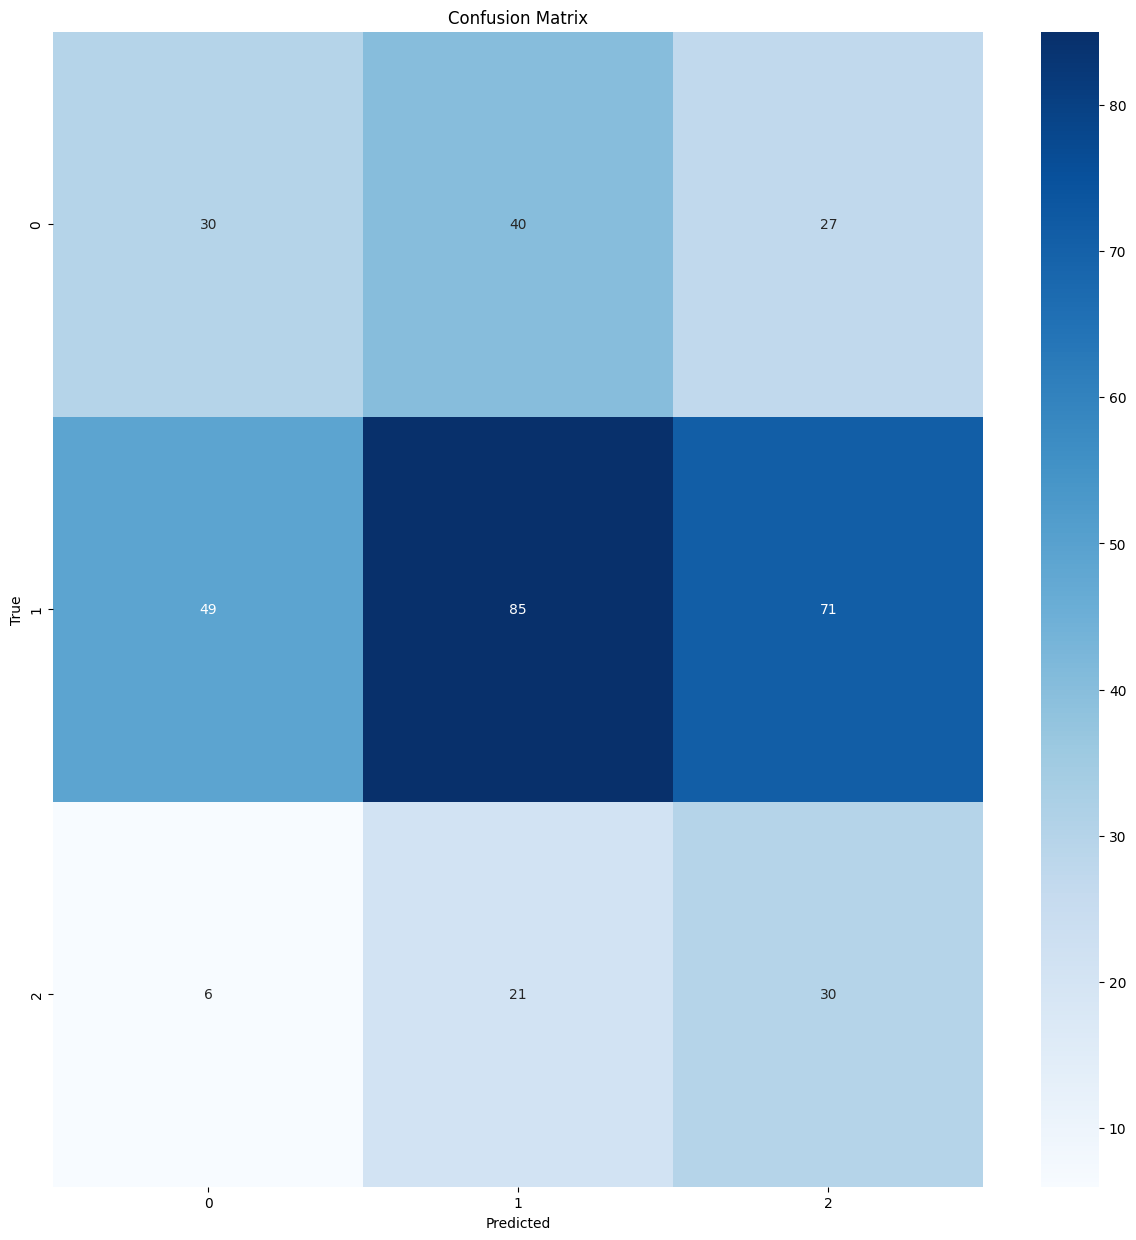

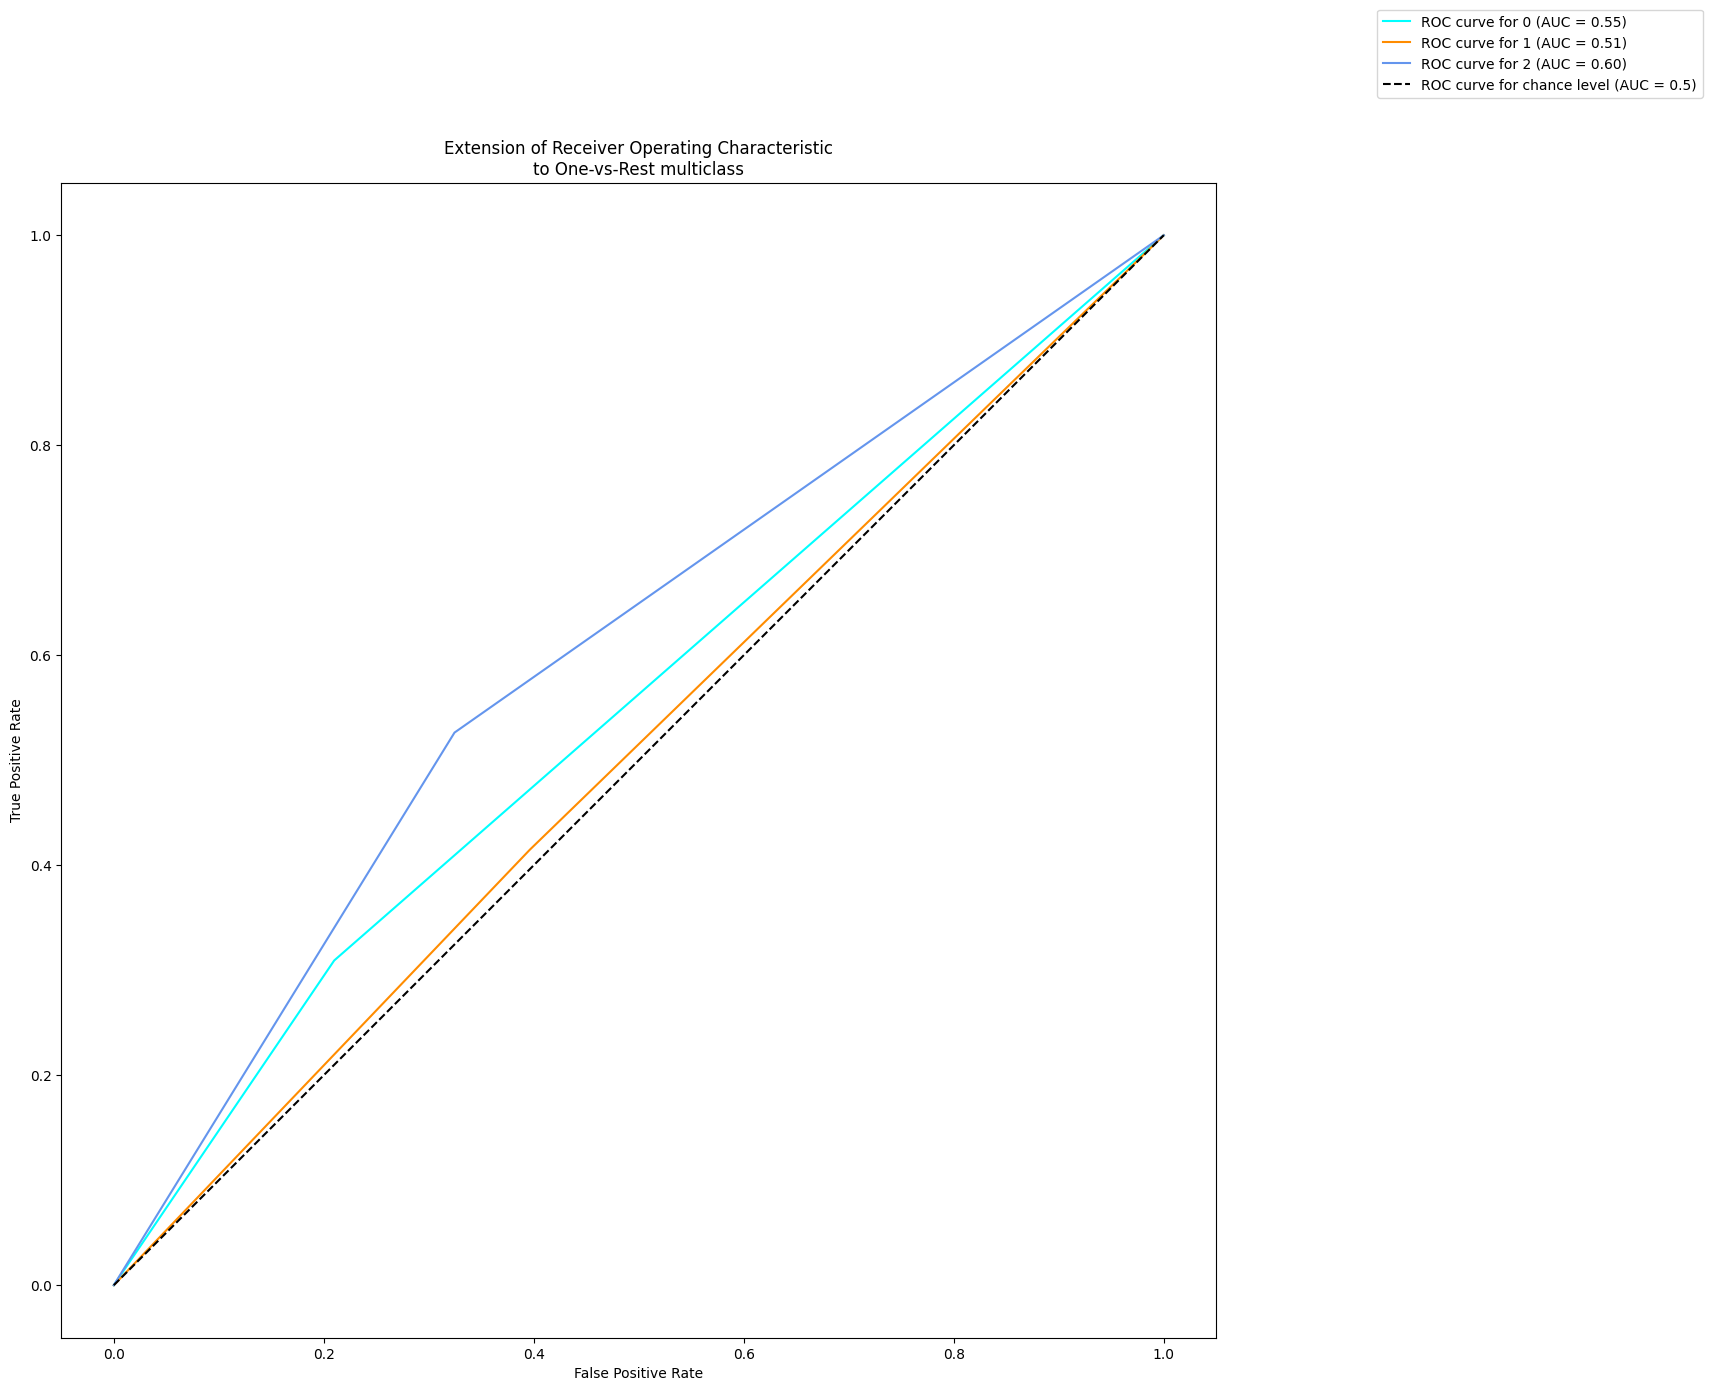

              precision    recall  f1-score   support

           0       0.35      0.31      0.33        97
           1       0.58      0.41      0.48       205
           2       0.23      0.53      0.32        57

    accuracy                           0.40       359
   macro avg       0.39      0.42      0.38       359
weighted avg       0.47      0.40      0.42       359



In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, freeze_backbone=True)